In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from collections import OrderedDict
from time import time

import numpy as np
import scipy as sp
import pandas as pd

from scipy.optimize import fmin_powell
from scipy import integrate
from scipy import linalg

from sklearn import linear_model
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

from matplotlib import rc
rc('font',**{'family':'sans-serif'})
rc('text', usetex=False)
#rc('text.latex',preamble=r'\usepackage[utf8]{inputenc}')
#rc('text.latex',preamble=r'\usepackage[russian]{babel}')
rc('axes', **{'titlesize': '16', 'labelsize': '16'})
rc('legend', **{'fontsize': '16'})
rc('figure', **{'dpi' : 150})

## Модельные методы классификации

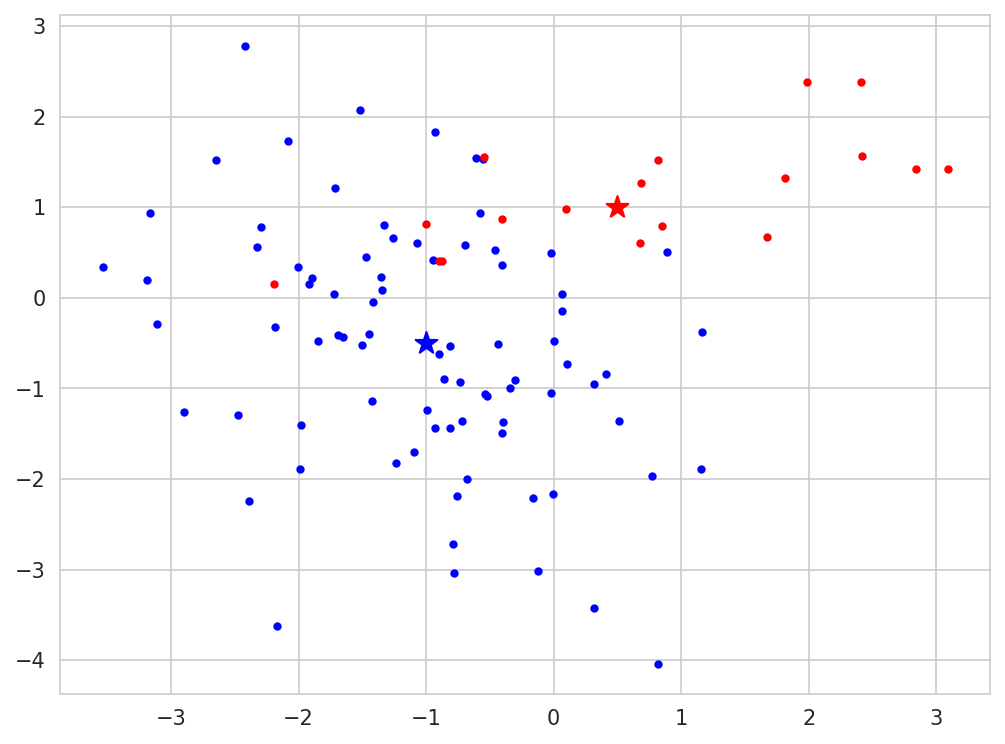

In [2]:
def sample_mixture(N, pi, mu1, sigma1, mu2, sigma2):
    z = np.array( np.random.rand(N) < pi, dtype=int)
    res = np.zeros((N, 2))
    res[np.where(z == 1)] = np.random.multivariate_normal(mu1, sigma1, np.sum(z))
    res[np.where(z == 0)] = np.random.multivariate_normal(mu2, sigma2, N-np.sum(z))
    return z, res

def plot_points(ax, x, z, mu1, mu2):
    ax.scatter(x[np.where(z==1), 0], x[np.where(z==1), 1], marker='.', color='b')
    ax.scatter(x[np.where(z==0), 0], x[np.where(z==0), 1], marker='.', color='r')
    ax.scatter([mu1[0]], [mu1[1]], marker='*', s=120, color='b')
    ax.scatter([mu2[0]], [mu2[1]], marker='*', s=120, color='r')


mu1, sigma1 = np.array([-1, -.5]), np.array([[1, -.5], [-.5, 2]])
mu2, sigma2 = np.array([.5, 1]), np.array([[2, .5], [.5, .5]])
z, x = sample_mixture(100, 0.7, mu1, sigma1, mu2, sigma2)
test_z, test_x = sample_mixture(100, 0.7, mu1, sigma1, mu2, sigma2)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
plot_points(ax, x, z, mu1, mu2)

In [3]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(store_covariance=True)
z_lda = lda.fit(x, z).predict(x)

qda = QuadraticDiscriminantAnalysis(store_covariance=True)
z_qda = qda.fit(x, z).predict(x)

In [4]:
from matplotlib import colors
cmap = colors.LinearSegmentedColormap(
    'red_blue_classes',
    {'red': [(0, 1, 1), (1, 0.7, 0.7)],
     'green': [(0, 0.7, 0.7), (1, 0.7, 0.7)],
     'blue': [(0, 0.7, 0.7), (1, 1, 1)]})

def plot_ellipse(ax, mu, sigma, color):
    v, w = sp.linalg.eigh(sigma)
    u = w[0] / sp.linalg.norm(w[0])
    angle = np.arctan(u[1] / u[0])
    angle = 180 * angle / np.pi
    ell = mpl.patches.Ellipse(mu, 2 * v[0] ** 0.5, 2 * v[1] ** 0.5,
                              180 + angle, facecolor=color,
                              edgecolor='black', linewidth=2)
    ell.set_clip_box(ax.bbox)
    ell.set_alpha(0.2)
    ax.add_artist(ell)
    ax.scatter(mu[0], mu[1], marker='+', color=color, s=100)

def plot_colormesh(ax, model):
    nx, ny = 100, 100
    x_min, x_max = plt.xlim()
    y_min, y_max = plt.ylim()
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx), np.linspace(y_min, y_max, ny))
    Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    Z = Z[:, 1].reshape(xx.shape)
    plt.pcolormesh(xx, yy, Z, cmap=cmap,
                   norm=colors.Normalize(0., 1.), zorder=0)
    plt.contour(xx, yy, Z, [0.5], linewidths=2., colors='white')    
    plt.contour(xx, yy, Z, [0.2, 0.4, 0.6, 0.8], linewidths=.8, colors='white')    

LDA priors: [0.18 0.82]


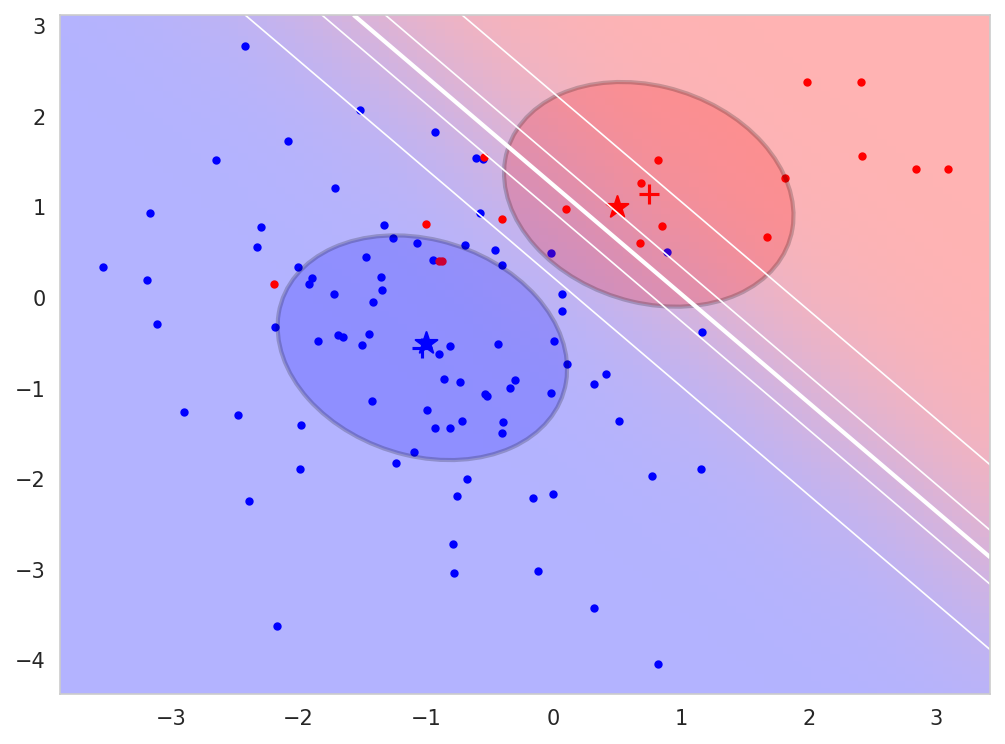

In [5]:
print("LDA priors: %s" % lda.priors_)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
plot_points(ax, x, z, mu1, mu2)
plot_ellipse(ax, lda.means_[0], lda.covariance_, 'r')
plot_ellipse(ax, lda.means_[1], lda.covariance_, 'b')
plot_colormesh(ax, lda)
plt.show()

QDA priors: [0.18 0.82]


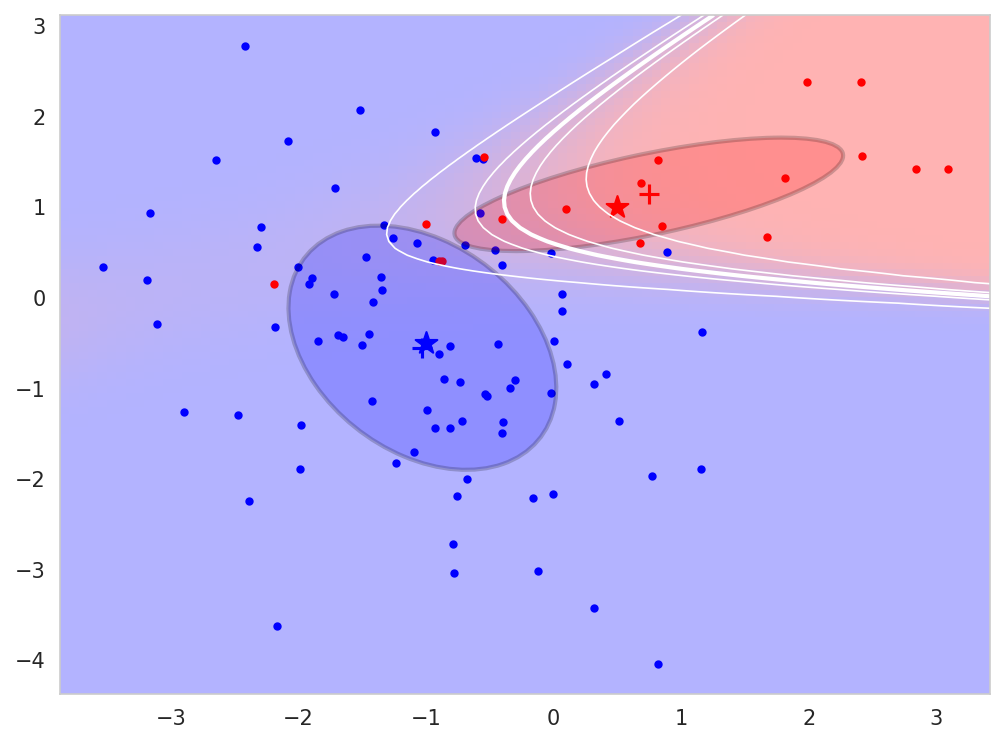

In [6]:
print("QDA priors: %s" % qda.priors_)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
plot_points(ax, x, z, mu1, mu2)
plot_ellipse(ax, qda.means_[0], qda.covariance_[0], 'r')
plot_ellipse(ax, qda.means_[1], qda.covariance_[1], 'b')
plot_colormesh(ax, qda)
plt.show()

## Логистическая регрессия

In [7]:
logregr = linear_model.LogisticRegression()
z_logregr = logregr.fit(x, z).predict(x)

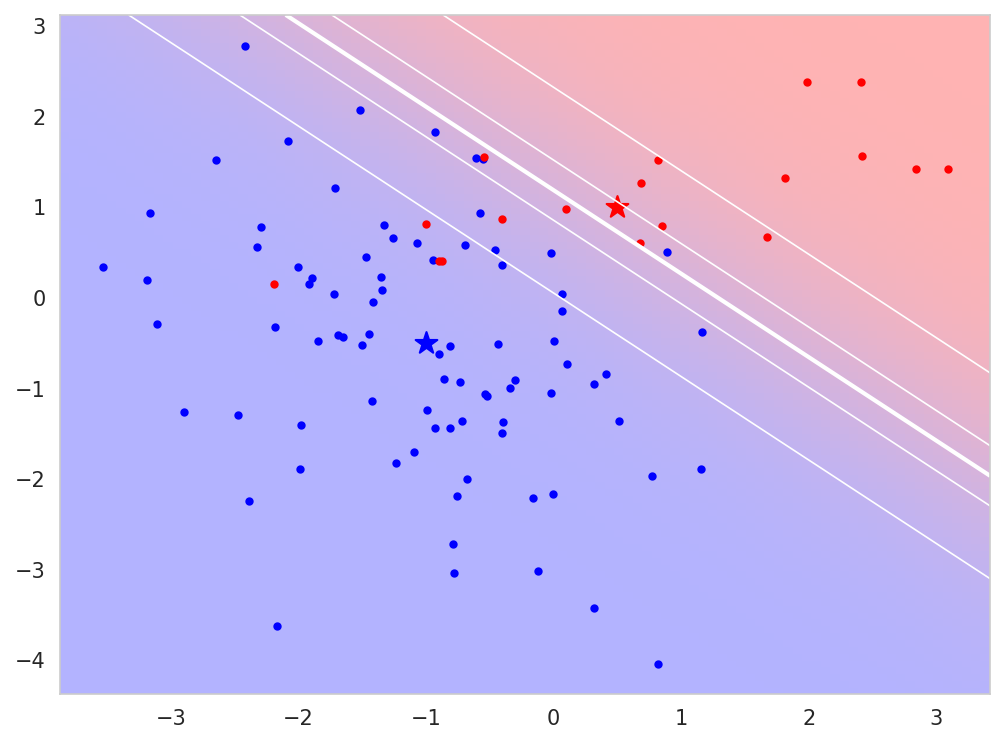

In [8]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
plot_points(ax, x, z, mu1, mu2)
plot_colormesh(ax, logregr)
plt.show()

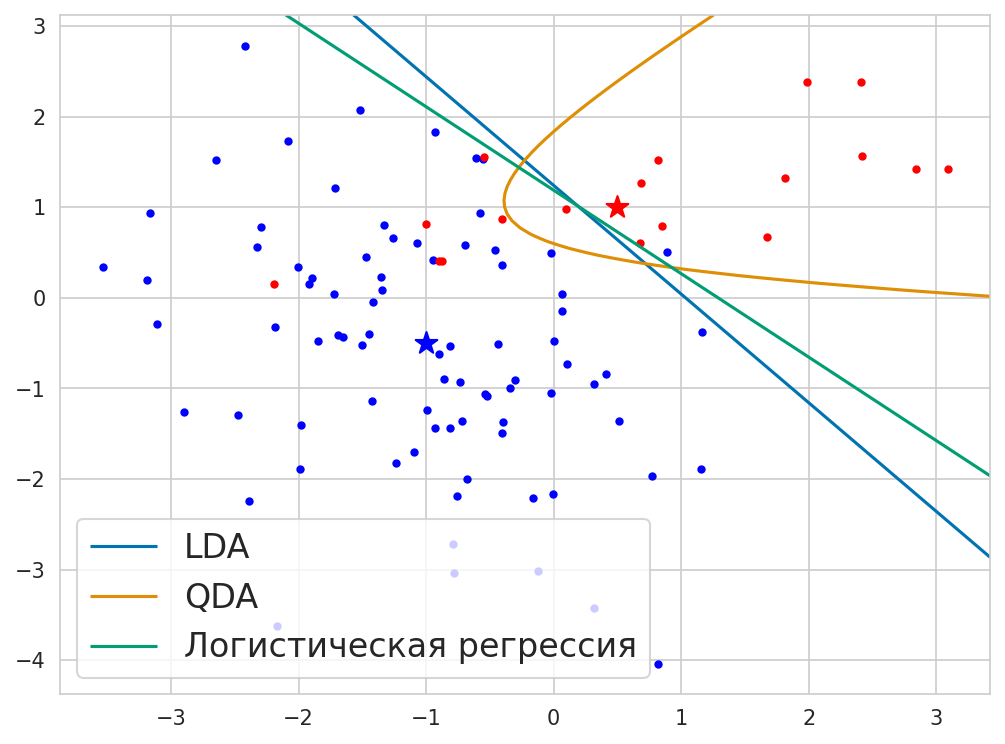

In [9]:
def plot_decision_boundary(ax, model, color, label):
    nx, ny = 100, 100
    x_min, x_max = plt.xlim()
    y_min, y_max = plt.ylim()
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx), np.linspace(y_min, y_max, ny))
    Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    Z = Z[:, 1].reshape(xx.shape)
    p = ax.contour(xx, yy, Z, [0.5], linewidths=1.5, colors=[color])
    p.collections[0].set_label(label)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
plot_points(ax, x, z, mu1, mu2)
p = plot_decision_boundary(ax, lda, palette[0], "LDA")
plot_decision_boundary(ax, qda, palette[1], "QDA")
plot_decision_boundary(ax, logregr, palette[2], "Логистическая регрессия")
plt.legend()
plt.show()